## setup

In [ ]:
import einops
import h5py
import numpy as np
import random
import re
import time
import torch

from dataclasses import dataclass
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

## utils

In [ ]:
# ==================
# function: set seed
# ==================
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)

    # ensures deterministic operations on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode


# ========================
# function: get directions
# ========================
def get_directions(linear_probe: torch.Tensor, options: int, mappings: Dict[str, int], verbose: bool=True) -> Dict[str, torch.Tensor]:
    """
    extract directions (unormalized) from linear probe
    """
    directions = linear_probe.detach().cpu().numpy()
    mapping = mappings["relation"]

    # create a mapping from class names to their weight vectors
    directions_dict = {}
    for relation, relation_index in mapping.items():
        if relation_index < options:
            directions_dict[relation] = directions[:, int(relation_index)]

    if verbose:
        for relation in mapping.items():
            print(f"shape of direction {str(relation[0])} vector (d_model,) = {directions_dict[relation[0]].shape}" if verbose else "")

    return directions_dict

## data utils

In [ ]:
# =========================
# function: parse sentences
# =========================
def parse_sentences(
    sentences: List[str],
    verbose: bool = True,
    num_sample_triplets: int = 100
) -> Dict[str, List]:
    """
    Parses sentences into structured triplets with precise relation extraction.
    """
    start_time = time.time()

    triplets = []
    valid_indices = []

    # Updated regex pattern to capture the full multi-word relation
    pattern = r"The\s+(.*?)\s+is\s+(.*)\s+the\s+(.*?)\."

    for i, sentence in enumerate(sentences):
        # decode the byte string to a regular string
        sentence = sentence.decode('utf-8')
        match = re.match(pattern, sentence, re.IGNORECASE)
        if match:
            obj1 = match.group(1).strip()
            relation = match.group(2).strip()
            obj2 = match.group(3).strip()
            triplets.append((obj1, relation, obj2))
            valid_indices.append(i)

    if verbose:
        print("\n=== triplets ===")
        for i in range(min(num_sample_triplets, len(triplets))):
            print(f"{i}: {triplets[i]}")

    return {
        "triplets": triplets,
        "valid_indices": valid_indices
    }


# =========================
# function: encode triplets
# =========================
def encode_triplets(
    triplets: List[Tuple[str, str, str]],
    verbose: bool = True
) -> Tuple[Dict[str, np.ndarray], Dict[str, Dict[str, int]]]:
    """
    encode triplets for model training
    """
    start_time = time.time()
    print("encoding triplets..." if verbose else "")

    # extract separate components
    objects1, relations, objects2 = zip(*triplets)

    # filter out empty strings
    relations = [rel if rel else "UNKNOWN" for rel in relations]

    # encode each component
    rel_encoder = LabelEncoder()
    rel_labels = rel_encoder.fit_transform(relations)


    labels = {"relation": rel_labels}

    # create mapping dictionaries for later analysis
    rel_mapping = dict(zip(rel_encoder.classes_, range(len(rel_encoder.classes_))))
    mappings = {"relation": rel_mapping}

    if verbose:
        print(f"found {len(rel_mapping)} unique relations")

        # Print some of the unique relations
        print("\nrelations used:")
        sample_relations = list(rel_mapping.keys())
        for i, rel in enumerate(sample_relations):
            print(f"{i}: {rel}")

        print(f"encoding completed in {time.time() - start_time:.2f} seconds")

    return labels, mappings

# ============================
# function: prepare data split
# ============================
def prepare_data_split(layer_data: torch.Tensor, valid_indices: List[int], labels: Dict[str, np.ndarray], test_size: float=0.2) -> Dict[str, torch.Tensor]:
    """
    prepare single train/test split for all labels
    """
    # filter embeddings to keep only valid indices
    X = layer_data[valid_indices]

    # create a single train/test split for all labels
    X_train, X_test, y_rel_train, y_rel_test = train_test_split(
        X,
        labels["relation"],
        test_size=test_size,
        random_state=42
        )

    # convert to PyTorch tensors
    X_train_tensor = X_train.clone().detach().float()
    X_test_tensor = X_test.clone().detach().float()

    y_rel_train_tensor = torch.tensor(y_rel_train, dtype=torch.long)
    y_rel_test_tensor = torch.tensor(y_rel_test, dtype=torch.long)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_rel_train': y_rel_train_tensor,
        'y_rel_test': y_rel_test_tensor,
        }


# =============================
# function: create data loaders
# =============================
def create_data_loaders(split_data: Dict[str, torch.Tensor], batch_size: int=256) -> Dict[str, Dict[str, TensorDataset]]:
    """
    create data loaders for training and testing
    """
    # create training dataset
    train_rel_dataset = TensorDataset(split_data['X_train'], split_data['y_rel_train'])

    # create test dataset
    test_rel_dataset = TensorDataset(split_data['X_test'], split_data['y_rel_test'])

    # create data loaders
    train_rel_loader = DataLoader(train_rel_dataset, batch_size=batch_size, shuffle=True)
    test_rel_loader = DataLoader(test_rel_dataset, batch_size=batch_size)

    return {
        'train': {
            'relation': train_rel_loader,
            },
        'test': {
            'relation': test_rel_loader,
            }
        }

## linear probes

In [ ]:
# ============================
# class: probe train arguments
# ============================
@dataclass
class ProbeTrainingArgs:
    verbose: bool = False
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # layer information
    layer_name: str = "layer_8"

    # spatial relation state
    options: int = 4
    d_model: int = 3072

    # standard training hyperparams
    epochs: int = 10

    # hyperparams for optimizer
    lr: float = 1e-3

    # cpde to get randomly initialized probe
    def setup_probe(self) -> torch.Tensor:
        linear_probe = torch.randn(self.d_model, self.options, device=self.device) / np.sqrt(self.d_model)
        linear_probe.requires_grad = True
        print(f"shape of linear probe is: d_model = {linear_probe.shape[0]} and options = {linear_probe.shape[-1]}" if self.verbose else "")
        return linear_probe

# ===========================
# class: Linear probe trainer
# ===========================
class LinearProbeTrainer:
    def __init__(self, args: ProbeTrainingArgs, dataloader: torch.utils.data.DataLoader):
        self.args = args
        self.linear_probe = args.setup_probe()
        self.dataloader = dataloader

    def train(self):
        if self.args.verbose:
            print(f"\ntraining a linear probe for spatial relations of layer {self.args.layer_name} for {self.args.epochs} epochs ...\n")
        self.step = 0

        # define optimizer
        optimizer = torch.optim.Adam(
            [self.linear_probe], lr=self.args.lr
        )

        # define loss criterion
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(self.args.epochs):
            total_loss = 0
            correct = 0
            total = 0

            for inputs, targets in tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{self.args.epochs}"):

                # move data to device
                inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)

                # get probe output
                probe_preds = einops.einsum(
                    inputs,
                    self.linear_probe,
                    "batch d_model, d_model options -> batch options",
                    )

                # compute loss
                loss = criterion(probe_preds, targets)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # update loss and accuracy
                total_loss += loss.item()
                _, predicted = torch.max(probe_preds.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

            # print epoch results
            avg_loss = total_loss / len(self.dataloader)
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{self.args.epochs}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%")


# ========================
# function: evaluate probe
# ========================
def evaluate_probe(linear_probe: torch.Tensor, dataloader: DataLoader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    evaluate a linear probe model
    """
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for inputs, targets in dataloader:

            # move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # get linear probe preds
            probe_preds = einops.einsum(
                inputs,
                linear_probe,
                "batch d_model, d_model options -> batch options",
                )
            _, predicted = torch.max(probe_preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=1)

    return accuracy, report

## main

In [ ]:
# mount google drive
drive.mount('/content/drive')

# config variables
VERBOSE = True
selected_layer: int = 24

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"we are using {device}" if VERBOSE else "")

# seet rng seed
set_seed(54321)

# define the dataset name
# dataset_path = "drive/MyDrive/datasets-sentences/simple_3D_extended_579960_sentences.h5"
# dataset_path = "drive/MyDrive/datasets-sentences/simple_3D_extended_716400_sentences.h5"
dataset_path = "drive/MyDrive/datasets-sentences/simple_3D_extended_1120500_sentences_layer24.h5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
we are using cuda


In [ ]:
# load the data
dataset = h5py.File(dataset_path, 'r')

# list the datasets (for example, "sentences" and possibly an "embeddings" group)
print(list(dataset.keys()))

# number of sentences used
n_sentences = 200000

# define sentences and embeddings
sentences = dataset['sentences'][:n_sentences]
embeddings = {}

layers_list = [24]
for k in layers_list:
    layer_name = f"layer_{k}"
    embeddings[layer_name] = dataset['embeddings'][layer_name][:n_sentences, :]



if VERBOSE:
    print("\n" + "=" * 40)
    print("📊 dataset and embedding statistics")
    print("=" * 40)

    # dataset statistics
    print(f"\n🔢 dataset overview:")
    print(f"• total sentences: {len(sentences):,}")

    # layer details
    print(f"\n🧬 embedding layers extracted:")
    for k in layers_list:
        layer_name = f"layer_{k}"
        layer_shape = embeddings[layer_name].shape
        print(f"• layer {k}: shape: {layer_shape}")
    print("\n" + "=" * 40)

['embeddings', 'sentences']

📊 dataset and embedding statistics

🔢 dataset overview:
• total sentences: 200,000

🧬 embedding layers extracted:
• layer 24: shape: (200000, 3072)



## training linear probes


In [ ]:
# transform data to torch
layers_tensors = {}
for k in layers_list:
    layer_name = f"layer_{k}"
    layers_tensors[layer_name] = torch.tensor(embeddings[layer_name][:])
    print(f"layer {k} embeddings shape (# sentences, d_model): {layers_tensors[layer_name].shape}" if VERBOSE else "")

layer 24 embeddings shape (# sentences, d_model): torch.Size([200000, 3072])


In [ ]:
# parse senteces
pars_sentences = parse_sentences(sentences, verbose=VERBOSE, num_sample_triplets=20)


=== triplets ===
0: ('pen', 'above', 'pencil')
1: ('pen', 'below', 'pencil')
2: ('pen', 'to the right of', 'pencil')
3: ('pen', 'to the left of', 'pencil')
4: ('pen', 'in front of', 'pencil')
5: ('pen', 'behind', 'pencil')
6: ('pen', 'diagonally above and to the right of', 'pencil')
7: ('pen', 'diagonally above and to the left of', 'pencil')
8: ('pen', 'diagonally below and to the right of', 'pencil')
9: ('pen', 'diagonally below and to the left of', 'pencil')
10: ('pen', 'diagonally above and in front of', 'pencil')
11: ('pen', 'diagonally above and behind', 'pencil')
12: ('pen', 'diagonally below and in front of', 'pencil')
13: ('pen', 'diagonally below and behind', 'pencil')
14: ('pen', 'diagonally to the right of and in front of', 'pencil')
15: ('pen', 'diagonally to the left of and in front of', 'pencil')
16: ('pen', 'diagonally to the right of and behind', 'pencil')
17: ('pen', 'diagonally to the left of and behind', 'pencil')
18: ('pen', 'above', 'eraser')
19: ('pen', 'below', 

In [ ]:
# encode triplets
labels, mappings = encode_triplets(pars_sentences["triplets"], verbose=VERBOSE)

encoding triplets...
found 18 unique relations

relations used:
0: above
1: behind
2: below
3: diagonally above and behind
4: diagonally above and in front of
5: diagonally above and to the left of
6: diagonally above and to the right of
7: diagonally below and behind
8: diagonally below and in front of
9: diagonally below and to the left of
10: diagonally below and to the right of
11: diagonally to the left of and behind
12: diagonally to the left of and in front of
13: diagonally to the right of and behind
14: diagonally to the right of and in front of
15: in front of
16: to the left of
17: to the right of
encoding completed in 0.60 seconds


In [ ]:
# prepare layer data for split
batch_size = {}
dataloaders = {}
test_size = 0.2

# get number of relations
options = len(mappings["relation"])
print(f"number of unique relations: {options}" if VERBOSE else "")

for k in layers_list:
    layer_name = f"layer_{k}"
    batch_size[layer_name], d_model = layers_tensors[layer_name].shape
    print(f"layer data shape (num, d_model): {layers_tensors[layer_name].shape}" if VERBOSE else "")

    # create dataloaders
    split_data = prepare_data_split(layers_tensors[layer_name], pars_sentences["valid_indices"], labels, test_size=test_size)
    dataloaders[layer_name] = create_data_loaders(split_data, batch_size=1024)

number of unique relations: 18
layer data shape (num, d_model): torch.Size([200000, 3072])


In [ ]:
# train the linear probe
torch.set_grad_enabled(True)
args = {}
trainers = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    args[layer_name] = ProbeTrainingArgs(
        d_model=d_model,
        options=options,
        layer_name=layer_name,
        epochs=150,
        lr=1e-3,
        verbose=VERBOSE
        )

    trainers[layer_name] = LinearProbeTrainer(args[layer_name], dataloader=dataloaders[layer_name]["train"]["relation"])      # we focus only on the spatial relation
    trainers[layer_name].train()

shape of linear probe is: d_model = 3072 and options = 18

training a linear probe for spatial relations of layer layer_24 for 150 epochs ...



Epoch 1/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/150: Loss=0.8446, Accuracy=80.40%


Epoch 2/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/150: Loss=0.2760, Accuracy=96.30%


Epoch 3/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/150: Loss=0.1707, Accuracy=98.19%


Epoch 4/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/150: Loss=0.1224, Accuracy=98.86%


Epoch 5/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/150: Loss=0.0935, Accuracy=99.26%


Epoch 6/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/150: Loss=0.0750, Accuracy=99.47%


Epoch 7/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/150: Loss=0.0618, Accuracy=99.60%


Epoch 8/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/150: Loss=0.0521, Accuracy=99.70%


Epoch 9/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/150: Loss=0.0446, Accuracy=99.75%


Epoch 10/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/150: Loss=0.0388, Accuracy=99.80%


Epoch 11/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/150: Loss=0.0341, Accuracy=99.83%


Epoch 12/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/150: Loss=0.0301, Accuracy=99.87%


Epoch 13/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/150: Loss=0.0268, Accuracy=99.89%


Epoch 14/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/150: Loss=0.0240, Accuracy=99.91%


Epoch 15/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/150: Loss=0.0218, Accuracy=99.92%


Epoch 16/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/150: Loss=0.0197, Accuracy=99.93%


Epoch 17/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/150: Loss=0.0179, Accuracy=99.94%


Epoch 18/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/150: Loss=0.0164, Accuracy=99.95%


Epoch 19/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/150: Loss=0.0150, Accuracy=99.95%


Epoch 20/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/150: Loss=0.0137, Accuracy=99.96%


Epoch 21/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/150: Loss=0.0126, Accuracy=99.97%


Epoch 22/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/150: Loss=0.0117, Accuracy=99.97%


Epoch 23/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/150: Loss=0.0108, Accuracy=99.98%


Epoch 24/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/150: Loss=0.0100, Accuracy=99.98%


Epoch 25/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/150: Loss=0.0093, Accuracy=99.98%


Epoch 26/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/150: Loss=0.0086, Accuracy=99.99%


Epoch 27/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/150: Loss=0.0080, Accuracy=99.99%


Epoch 28/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/150: Loss=0.0074, Accuracy=99.99%


Epoch 29/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/150: Loss=0.0069, Accuracy=99.99%


Epoch 30/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/150: Loss=0.0064, Accuracy=99.99%


Epoch 31/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31/150: Loss=0.0060, Accuracy=100.00%


Epoch 32/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32/150: Loss=0.0056, Accuracy=100.00%


Epoch 33/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33/150: Loss=0.0053, Accuracy=100.00%


Epoch 34/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34/150: Loss=0.0049, Accuracy=100.00%


Epoch 35/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35/150: Loss=0.0046, Accuracy=100.00%


Epoch 36/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36/150: Loss=0.0044, Accuracy=100.00%


Epoch 37/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37/150: Loss=0.0041, Accuracy=100.00%


Epoch 38/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38/150: Loss=0.0038, Accuracy=100.00%


Epoch 39/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39/150: Loss=0.0037, Accuracy=100.00%


Epoch 40/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 40/150: Loss=0.0034, Accuracy=100.00%


Epoch 41/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 41/150: Loss=0.0032, Accuracy=100.00%


Epoch 42/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 42/150: Loss=0.0030, Accuracy=100.00%


Epoch 43/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 43/150: Loss=0.0029, Accuracy=100.00%


Epoch 44/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 44/150: Loss=0.0027, Accuracy=100.00%


Epoch 45/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 45/150: Loss=0.0025, Accuracy=100.00%


Epoch 46/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 46/150: Loss=0.0024, Accuracy=100.00%


Epoch 47/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 47/150: Loss=0.0022, Accuracy=100.00%


Epoch 48/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 48/150: Loss=0.0021, Accuracy=100.00%


Epoch 49/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 49/150: Loss=0.0020, Accuracy=100.00%


Epoch 50/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 50/150: Loss=0.0019, Accuracy=100.00%


Epoch 51/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 51/150: Loss=0.0018, Accuracy=100.00%


Epoch 52/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 52/150: Loss=0.0017, Accuracy=100.00%


Epoch 53/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 53/150: Loss=0.0016, Accuracy=100.00%


Epoch 54/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 54/150: Loss=0.0015, Accuracy=100.00%


Epoch 55/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 55/150: Loss=0.0014, Accuracy=100.00%


Epoch 56/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 56/150: Loss=0.0014, Accuracy=100.00%


Epoch 57/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 57/150: Loss=0.0013, Accuracy=100.00%


Epoch 58/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 58/150: Loss=0.0012, Accuracy=100.00%


Epoch 59/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 59/150: Loss=0.0011, Accuracy=100.00%


Epoch 60/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 60/150: Loss=0.0011, Accuracy=100.00%


Epoch 61/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 61/150: Loss=0.0010, Accuracy=100.00%


Epoch 62/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 62/150: Loss=0.0010, Accuracy=100.00%


Epoch 63/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 63/150: Loss=0.0009, Accuracy=100.00%


Epoch 64/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 64/150: Loss=0.0009, Accuracy=100.00%


Epoch 65/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 65/150: Loss=0.0008, Accuracy=100.00%


Epoch 66/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 66/150: Loss=0.0008, Accuracy=100.00%


Epoch 67/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 67/150: Loss=0.0008, Accuracy=100.00%


Epoch 68/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 68/150: Loss=0.0007, Accuracy=100.00%


Epoch 69/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 69/150: Loss=0.0007, Accuracy=100.00%


Epoch 70/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 70/150: Loss=0.0007, Accuracy=100.00%


Epoch 71/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 71/150: Loss=0.0006, Accuracy=100.00%


Epoch 72/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 72/150: Loss=0.0006, Accuracy=100.00%


Epoch 73/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 73/150: Loss=0.0006, Accuracy=100.00%


Epoch 74/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 74/150: Loss=0.0005, Accuracy=100.00%


Epoch 75/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 75/150: Loss=0.0005, Accuracy=100.00%


Epoch 76/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 76/150: Loss=0.0005, Accuracy=100.00%


Epoch 77/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 77/150: Loss=0.0005, Accuracy=100.00%


Epoch 78/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 78/150: Loss=0.0005, Accuracy=100.00%


Epoch 79/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 79/150: Loss=0.0004, Accuracy=100.00%


Epoch 80/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 80/150: Loss=0.0004, Accuracy=100.00%


Epoch 81/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 81/150: Loss=0.0004, Accuracy=100.00%


Epoch 82/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 82/150: Loss=0.0004, Accuracy=100.00%


Epoch 83/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 83/150: Loss=0.0003, Accuracy=100.00%


Epoch 84/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 84/150: Loss=0.0003, Accuracy=100.00%


Epoch 85/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 85/150: Loss=0.0003, Accuracy=100.00%


Epoch 86/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 86/150: Loss=0.0003, Accuracy=100.00%


Epoch 87/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 87/150: Loss=0.0004, Accuracy=100.00%


Epoch 88/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 88/150: Loss=0.0003, Accuracy=100.00%


Epoch 89/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 89/150: Loss=0.0003, Accuracy=100.00%


Epoch 90/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 90/150: Loss=0.0003, Accuracy=100.00%


Epoch 91/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 91/150: Loss=0.0002, Accuracy=100.00%


Epoch 92/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 92/150: Loss=0.0002, Accuracy=100.00%


Epoch 93/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 93/150: Loss=0.0002, Accuracy=100.00%


Epoch 94/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 94/150: Loss=0.0002, Accuracy=100.00%


Epoch 95/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 95/150: Loss=0.0002, Accuracy=100.00%


Epoch 96/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 96/150: Loss=0.0002, Accuracy=100.00%


Epoch 97/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 97/150: Loss=0.0002, Accuracy=100.00%


Epoch 98/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 98/150: Loss=0.0002, Accuracy=100.00%


Epoch 99/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 99/150: Loss=0.0002, Accuracy=100.00%


Epoch 100/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 100/150: Loss=0.0002, Accuracy=100.00%


Epoch 101/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 101/150: Loss=0.0002, Accuracy=100.00%


Epoch 102/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 102/150: Loss=0.0002, Accuracy=100.00%


Epoch 103/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 103/150: Loss=0.0001, Accuracy=100.00%


Epoch 104/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 104/150: Loss=0.0001, Accuracy=100.00%


Epoch 105/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 105/150: Loss=0.0001, Accuracy=100.00%


Epoch 106/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 106/150: Loss=0.0001, Accuracy=100.00%


Epoch 107/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 107/150: Loss=0.0001, Accuracy=100.00%


Epoch 108/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 108/150: Loss=0.0001, Accuracy=100.00%


Epoch 109/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 109/150: Loss=0.0001, Accuracy=100.00%


Epoch 110/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 110/150: Loss=0.0001, Accuracy=100.00%


Epoch 111/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 111/150: Loss=0.0001, Accuracy=100.00%


Epoch 112/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 112/150: Loss=0.0001, Accuracy=100.00%


Epoch 113/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 113/150: Loss=0.0001, Accuracy=100.00%


Epoch 114/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 114/150: Loss=0.0001, Accuracy=100.00%


Epoch 115/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 115/150: Loss=0.0001, Accuracy=100.00%


Epoch 116/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 116/150: Loss=0.0001, Accuracy=100.00%


Epoch 117/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 117/150: Loss=0.0001, Accuracy=100.00%


Epoch 118/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 118/150: Loss=0.0001, Accuracy=100.00%


Epoch 119/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 119/150: Loss=0.0001, Accuracy=100.00%


Epoch 120/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 120/150: Loss=0.0001, Accuracy=100.00%


Epoch 121/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 121/150: Loss=0.0001, Accuracy=100.00%


Epoch 122/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 122/150: Loss=0.0001, Accuracy=100.00%


Epoch 123/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 123/150: Loss=0.0001, Accuracy=100.00%


Epoch 124/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 124/150: Loss=0.0001, Accuracy=100.00%


Epoch 125/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 125/150: Loss=0.0001, Accuracy=100.00%


Epoch 126/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 126/150: Loss=0.0001, Accuracy=100.00%


Epoch 127/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 127/150: Loss=0.0001, Accuracy=100.00%


Epoch 128/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 128/150: Loss=0.0000, Accuracy=100.00%


Epoch 129/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 129/150: Loss=0.0001, Accuracy=100.00%


Epoch 130/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 130/150: Loss=0.0000, Accuracy=100.00%


Epoch 131/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 131/150: Loss=0.0000, Accuracy=100.00%


Epoch 132/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 132/150: Loss=0.0000, Accuracy=100.00%


Epoch 133/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 133/150: Loss=0.0000, Accuracy=100.00%


Epoch 134/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 134/150: Loss=0.0000, Accuracy=100.00%


Epoch 135/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 135/150: Loss=0.0000, Accuracy=100.00%


Epoch 136/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 136/150: Loss=0.0000, Accuracy=100.00%


Epoch 137/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 137/150: Loss=0.0000, Accuracy=100.00%


Epoch 138/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 138/150: Loss=0.0000, Accuracy=100.00%


Epoch 139/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 139/150: Loss=0.0000, Accuracy=100.00%


Epoch 140/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 140/150: Loss=0.0000, Accuracy=100.00%


Epoch 141/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 141/150: Loss=0.0002, Accuracy=99.99%


Epoch 142/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 142/150: Loss=0.0000, Accuracy=100.00%


Epoch 143/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 143/150: Loss=0.0000, Accuracy=100.00%


Epoch 144/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 144/150: Loss=0.0000, Accuracy=100.00%


Epoch 145/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 145/150: Loss=0.0000, Accuracy=100.00%


Epoch 146/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 146/150: Loss=0.0000, Accuracy=100.00%


Epoch 147/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 147/150: Loss=0.0000, Accuracy=100.00%


Epoch 148/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 148/150: Loss=0.0000, Accuracy=100.00%


Epoch 149/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 149/150: Loss=0.0000, Accuracy=100.00%


Epoch 150/150:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 150/150: Loss=0.0000, Accuracy=100.00%


In [ ]:
# report accuracy
accuracy = {}
report = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    accuracy[layer_name], report[layer_name] = evaluate_probe(trainers[layer_name].linear_probe, dataloaders[layer_name]["test"]["relation"], device=device)
    print(f"Linear probe accuracy: {accuracy[layer_name]:.4f}" if VERBOSE else "")

Linear probe accuracy: 0.9998


In [ ]:
# extract the directions of each spatial relation as a Dict
directions = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    directions[layer_name] = get_directions(trainers[layer_name].linear_probe, options, mappings, verbose=VERBOSE)  # each direction has shape (d_model,)

shape of direction above vector (d_model,) = (3072,)
shape of direction behind vector (d_model,) = (3072,)
shape of direction below vector (d_model,) = (3072,)
shape of direction diagonally above and behind vector (d_model,) = (3072,)
shape of direction diagonally above and in front of vector (d_model,) = (3072,)
shape of direction diagonally above and to the left of vector (d_model,) = (3072,)
shape of direction diagonally above and to the right of vector (d_model,) = (3072,)
shape of direction diagonally below and behind vector (d_model,) = (3072,)
shape of direction diagonally below and in front of vector (d_model,) = (3072,)
shape of direction diagonally below and to the left of vector (d_model,) = (3072,)
shape of direction diagonally below and to the right of vector (d_model,) = (3072,)
shape of direction diagonally to the left of and behind vector (d_model,) = (3072,)
shape of direction diagonally to the left of and in front of vector (d_model,) = (3072,)
shape of direction diag

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


# =========================================
# function: check composition of directions
# =========================================
def check_composition_of_directions(directions: Dict[str, np.ndarray], verbose: bool = True) -> pd.DataFrame:
    """
    Check composition of directions among spatial relation probes in original and PCA-reduced space.

    Renders:
      1) Combined 3D unnormalized PCA quiver for all composition pairs.
      2) Individual 3D unnormalized quiver plots for each composition pair with distinct colors for atomic1, atomic2, composed, and direct.
      3) Individual 3D normalized quiver plots for each composition pair (unit-length vectors) with same color scheme.
      4) A 3D direct vs. composed comparison plot with dynamic limits.
      5) A unit sphere with normalized PCA vectors (direct dashed, composed solid) in unique colors.

    Assumes `directions[rel]` are NumPy arrays.
    """
    # Composition definitions
    composition_pairs = {
        "diagonally above and to the right of": ("above", "to the right of"),
        "diagonally above and to the left of": ("above", "to the left of"),
        "diagonally below and to the right of": ("below", "to the right of"),
        "diagonally below and to the left of": ("below", "to the left of"),
        "diagonally above and behind": ("above", "behind"),
        "diagonally above and in front of": ("above", "in front of"),
        "diagonally below and behind": ("below", "behind"),
        "diagonally below and in front of": ("below", "in front of"),
        "diagonally to the left of and behind": ("to the left of", "behind"),
        "diagonally to the left of and in front of": ("to the left of", "in front of"),
        "diagonally to the right of and behind": ("to the right of", "behind"),
        "diagonally to the right of and in front of": ("to the right of", "in front of")
    }
    results = []

    # Assemble data and compute PCA
    rels = list(directions.keys())
    W = np.stack([directions[r] for r in rels])
    pca3 = PCA(n_components=3)
    W3 = pca3.fit_transform(W)
    dir3 = dict(zip(rels, W3))

    # Compute metrics and verbose prints
    for idx, (name, (a1, a2)) in enumerate(composition_pairs.items()):
        # original metrics
        d = directions[name]
        c = directions[a1] + directions[a2]
        cs = cosine_similarity([d], [c])[0,0]
        euc = np.linalg.norm(d - c)
        ang = np.degrees(np.arccos(np.clip(cs, -1, 1)))
        results.append({'Relation': name, 'A1': a1, 'A2': a2,
                        'Cos(Orig)': cs, 'Euc(Orig)': euc, 'Ang(Orig)': ang})
        if verbose:
            print(f"\n🔀 Original Space: '{name}' ≈ '{a1}' + '{a2}'")
            print(f"  Cosine Similarity: {cs:.4f}")
            print(f"  Euclidean Diff: {euc:.4f}")
            print(f"  Angle: {ang:.2f}°")
        # PCA metrics
        d3 = dir3[name]
        c3 = dir3[a1] + dir3[a2]
        cs3 = cosine_similarity([d3], [c3])[0,0]
        e3 = np.linalg.norm(d3 - c3)
        a3 = np.degrees(np.arccos(np.clip(cs3, -1, 1)))
        results[idx].update({'Cos(PCA)': cs3, 'Euc(PCA)': e3, 'Ang(PCA)': a3})
        if verbose:
            print(f"\n🧭 PCA Space: '{name}' ≈ '{a1}' + '{a2}'")
            print(f"  Cosine Similarity: {cs3:.4f}")
            print(f"  Euclidean Diff: {e3:.4f}")
            print(f"  Angle: {a3:.2f}°")

    origin = np.zeros(3)
    global_mr = np.max(np.linalg.norm(W3, axis=1)) * 1.1
    cmap = plt.cm.get_cmap('tab20', len(composition_pairs))

    # 1) Combined 3D PCA quiver for all pairs
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for idx, (name, (a1, a2)) in enumerate(composition_pairs.items()):
        color = cmap(idx)
        v1, v2 = dir3[a1], dir3[a2]
        comp_vec = v1 + v2
        direct_vec = dir3[name]
        ax.quiver(*origin, *v1, length=1, normalize=False, color=color, alpha=0.3)
        ax.quiver(*origin, *v2, length=1, normalize=False, color=color, alpha=0.3)
        ax.quiver(*origin, *comp_vec, length=1, normalize=False, linestyle='-', color=color, alpha=0.8)
        ax.quiver(*origin, *direct_vec, length=1, normalize=False, linestyle='--', color=color, alpha=1.0, label=name)
    ax.set_xlim(-global_mr, global_mr); ax.set_ylim(-global_mr, global_mr); ax.set_zlim(-global_mr, global_mr)
    ax.set_title('3D PCA Composition (Unnormalized)')
    ax.legend(fontsize=6, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(); plt.show()

    # 2) Individual 3D unnormalized quiver plots
    for name, (a1, a2) in composition_pairs.items():
        v1, v2 = dir3[a1], dir3[a2]
        comp_vec = v1 + v2
        direct_vec = dir3[name]
        local_mr = max(np.linalg.norm(v1), np.linalg.norm(v2),
                       np.linalg.norm(comp_vec), np.linalg.norm(direct_vec)) * 1.1
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        # colors
        c1, c2, cc, cd = 'C0', 'C1', 'C2', 'C3'
        ax.quiver(*origin, *v1, length=1, normalize=False, color=c1, alpha=0.8, label=a1)
        ax.quiver(*origin, *v2, length=1, normalize=False, color=c2, alpha=0.8, label=a2)
        ax.quiver(*origin, *comp_vec, length=1, normalize=False, linestyle='-', color=cc, alpha=0.8, label=f'{a1}+{a2}')
        ax.quiver(*origin, *direct_vec, length=1, normalize=False, linestyle='--', color=cd, alpha=1.0, label=name)
        ax.set_xlim(-local_mr, local_mr); ax.set_ylim(-local_mr, local_mr); ax.set_zlim(-local_mr, local_mr)
        ax.set_title(f'3D PCA: {name} (Unnormalized)')
        ax.legend(fontsize=6, loc='upper left')
        plt.tight_layout(); plt.show()

    # 3) Individual 3D normalized quiver plots
    for name, (a1, a2) in composition_pairs.items():
        v1 = dir3[a1] / np.linalg.norm(dir3[a1])
        v2 = dir3[a2] / np.linalg.norm(dir3[a2])
        comp_vec = (dir3[a1] + dir3[a2])
        comp_vec = comp_vec / np.linalg.norm(comp_vec)
        direct_vec = dir3[name] / np.linalg.norm(dir3[name])
        # unit sphere limits
        unit_mr = 1.1
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        c1, c2, cc, cd = 'C0', 'C1', 'C2', 'C3'
        ax.quiver(*origin, *v1, length=1, normalize=False, color=c1, alpha=0.8, label=f'{a1} norm')
        ax.quiver(*origin, *v2, length=1, normalize=False, color=c2, alpha=0.8, label=f'{a2} norm')
        ax.quiver(*origin, *comp_vec, length=1, normalize=False, linestyle='-', color=cc, alpha=0.8, label=f'{a1}+{a2} norm')
        ax.quiver(*origin, *direct_vec, length=1, normalize=False, linestyle='--', color=cd, alpha=1.0, label=f'{name} norm')
        ax.set_xlim(-unit_mr, unit_mr); ax.set_ylim(-unit_mr, unit_mr); ax.set_zlim(-unit_mr, unit_mr)
        ax.set_title(f'3D PCA: {name} (Normalized)')
        ax.legend(fontsize=6, loc='upper left')
        plt.tight_layout(); plt.show()

    # 4) Direct vs. composed comparison plot
    comp_lengths = [np.linalg.norm(dir3[a1] + dir3[a2]) for _, (a1, a2) in composition_pairs.items()]
    direct_lengths = [np.linalg.norm(dir3[name]) for name in composition_pairs]
    max_len = max(comp_lengths + direct_lengths) * 1.1
    fig = plt.figure(figsize=(8, 6))
    ax2 = fig.add_subplot(111, projection='3d')
    for idx, (name, (a1, a2)) in enumerate(composition_pairs.items()):
        color = plt.cm.tab20(idx)
        comp_vec = dir3[a1] + dir3[a2]
        direct_vec = dir3[name]
        ax2.quiver(*origin, *comp_vec, length=1, normalize=False, linestyle='-', color=color, alpha=0.8, label=f'{name} comp')
        ax2.quiver(*origin, *direct_vec, length=1, normalize=False, linestyle='--', color=color, alpha=1.0, label=f'{name} direct')
    ax2.set_xlim(-max_len, max_len); ax2.set_ylim(-max_len, max_len); ax2.set_zlim(-max_len, max_len)
    ax2.set_title('3D PCA Direct vs Composed Comparison')
    ax2.legend(fontsize=6, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(); plt.show()

    # 5) Unit sphere normalized PCA vectors
    fig = plt.figure(figsize=(7, 7))
    ax3 = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones_like(u), np.cos(v))
    ax3.plot_wireframe(X, Y, Z, color='lightgray', linewidth=0.5)
    for idx, (name, (a1, a2)) in enumerate(composition_pairs.items()):
        color = plt.cm.tab20(idx)
        nd = dir3[name] / np.linalg.norm(dir3[name])
        nc = dir3[a1] + dir3[a2]
        nc = nc / np.linalg.norm(nc)
        ax3.plot([0, nd[0]], [0, nd[1]], [0, nd[2]], linestyle='--', linewidth=2, color=color, label=name)
        ax3.plot([0, nc[0]], [0, nc[1]], [0, nc[2]], linestyle='-', linewidth=2, color=color, label=f'{name} comp')
    ax3.set_title('Unit Sphere: Direct vs Composed')
    ax3.legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.set_axis_off()
    plt.tight_layout(); plt.show()

    return pd.DataFrame(results)


Composition of directions for layer layer_24

🔀 Original Space: 'diagonally above and to the right of' ≈ 'above' + 'to the right of'
  Cosine Similarity: 0.4029
  Euclidean Diff: 26.2543
  Angle: 66.24°

🧭 PCA Space: 'diagonally above and to the right of' ≈ 'above' + 'to the right of'
  Cosine Similarity: 0.8889
  Euclidean Diff: 16.6978
  Angle: 27.27°

🔀 Original Space: 'diagonally above and to the left of' ≈ 'above' + 'to the left of'
  Cosine Similarity: 0.3985
  Euclidean Diff: 26.4772
  Angle: 66.51°

🧭 PCA Space: 'diagonally above and to the left of' ≈ 'above' + 'to the left of'
  Cosine Similarity: 0.8646
  Euclidean Diff: 16.0073
  Angle: 30.16°

🔀 Original Space: 'diagonally below and to the right of' ≈ 'below' + 'to the right of'
  Cosine Similarity: 0.3462
  Euclidean Diff: 26.3215
  Angle: 69.75°

🧭 PCA Space: 'diagonally below and to the right of' ≈ 'below' + 'to the right of'
  Cosine Similarity: 0.8759
  Euclidean Diff: 15.2599
  Angle: 28.84°

🔀 Original Space: 'diago

<ipython-input-21-6f55cfc90bc8>:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(composition_pairs))


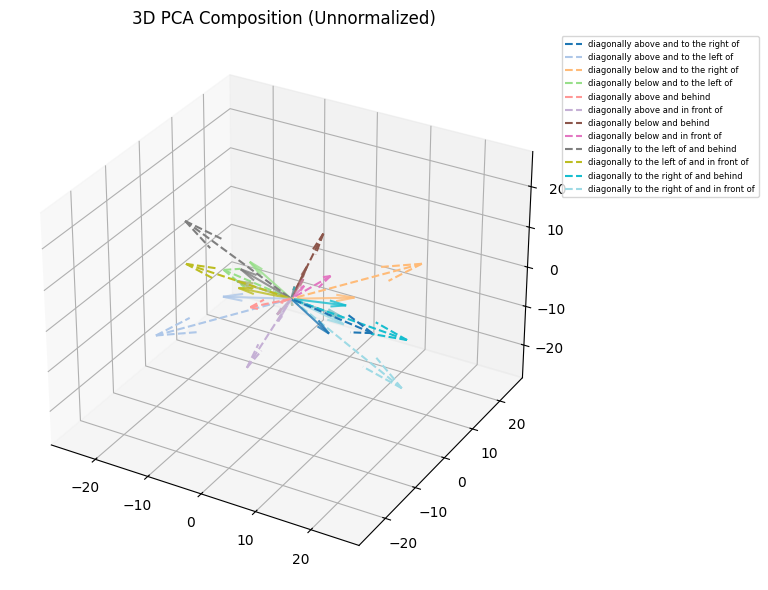

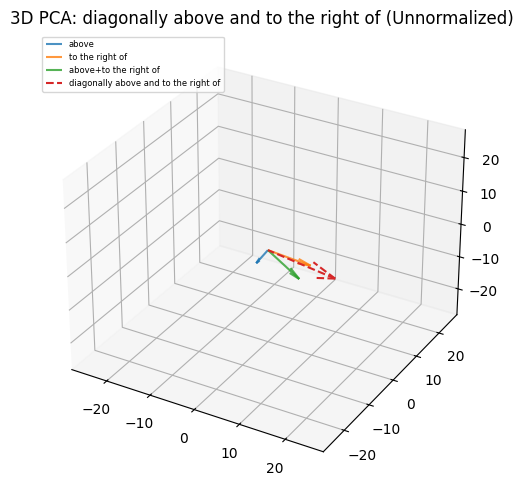

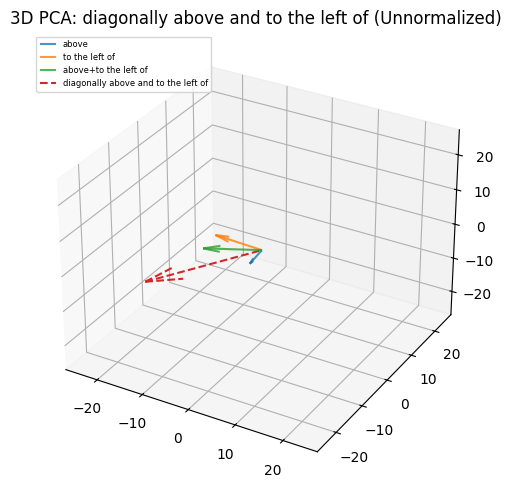

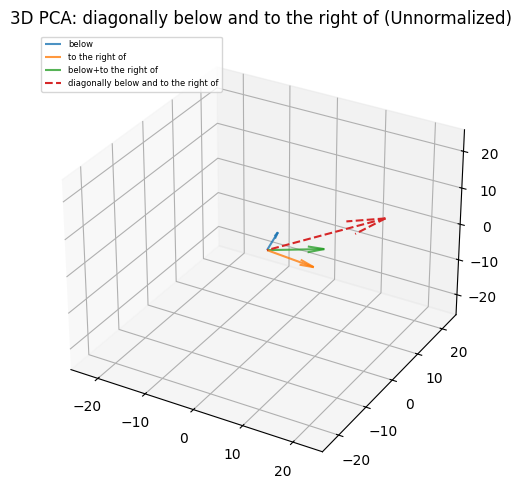

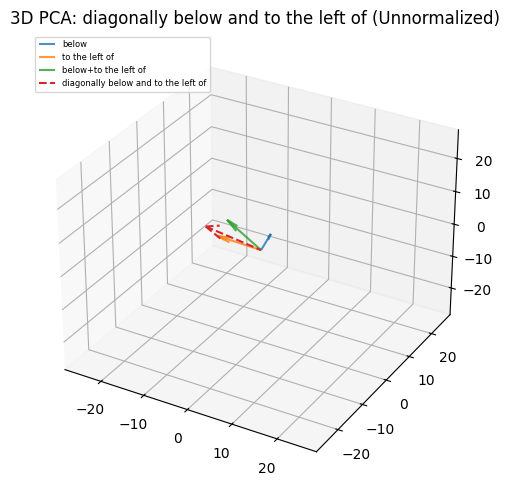

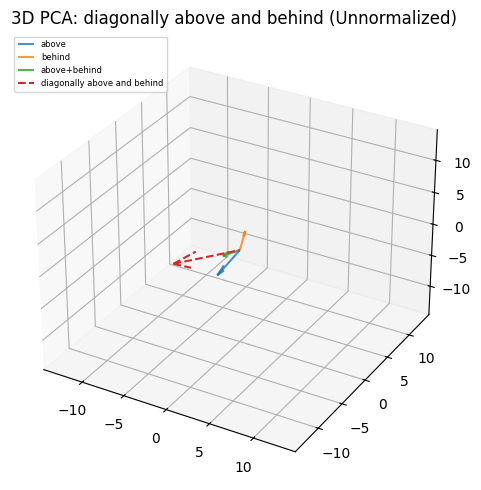

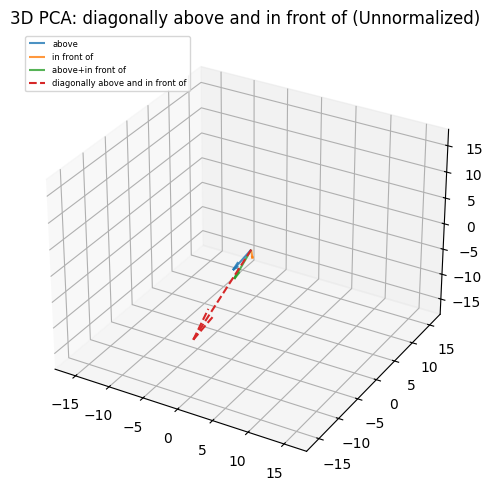

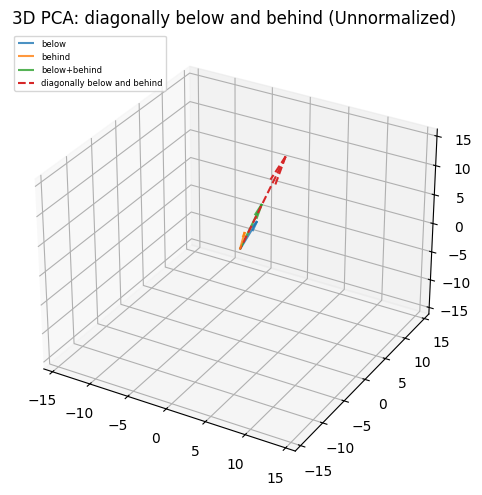

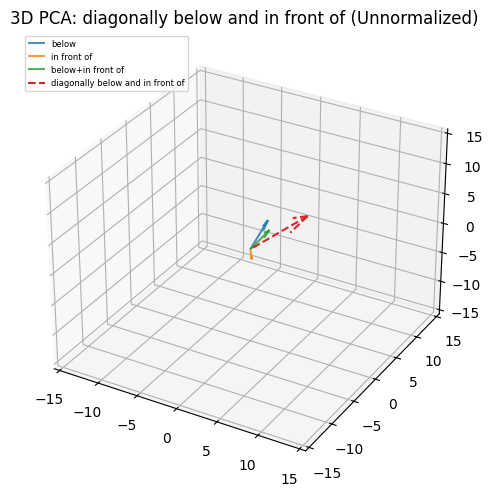

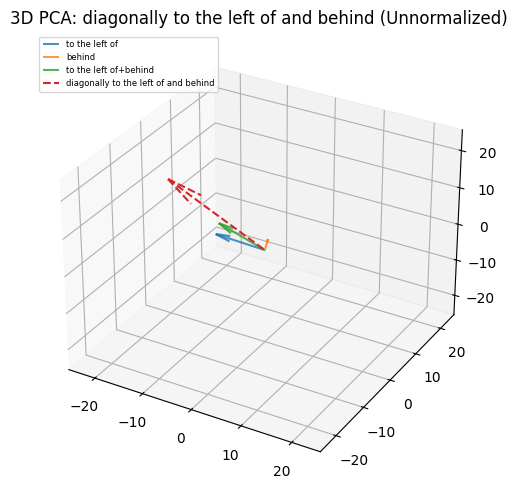

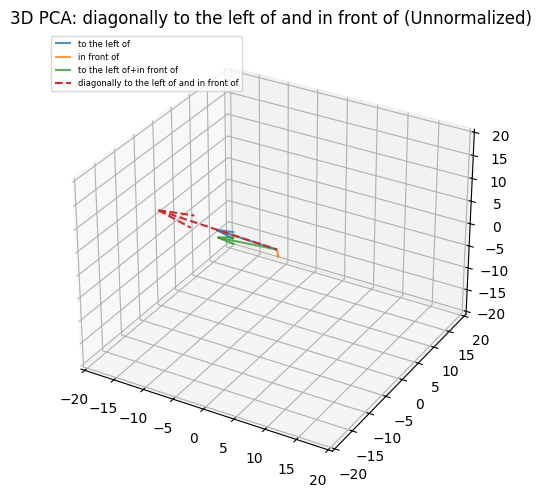

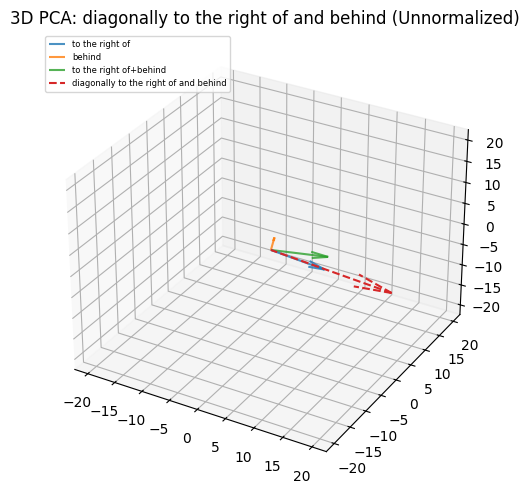

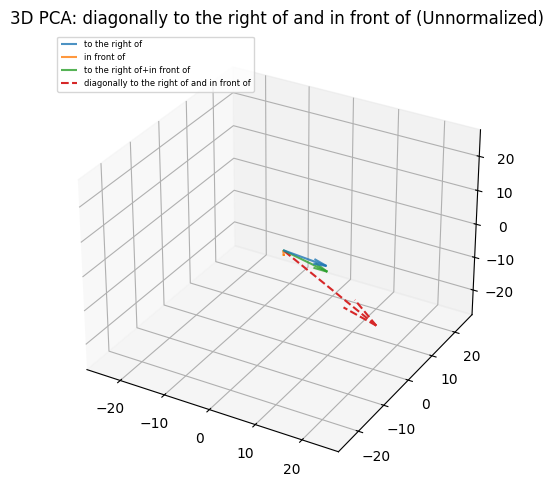

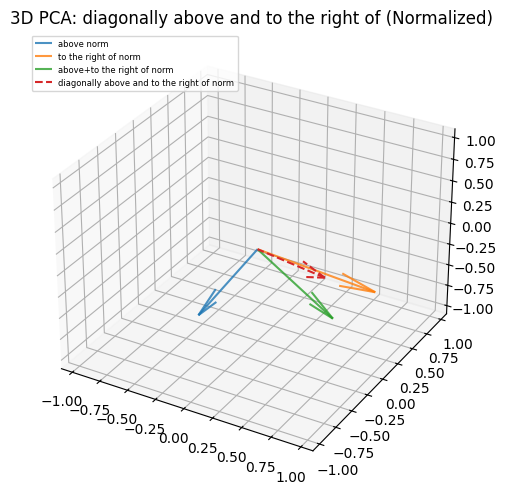

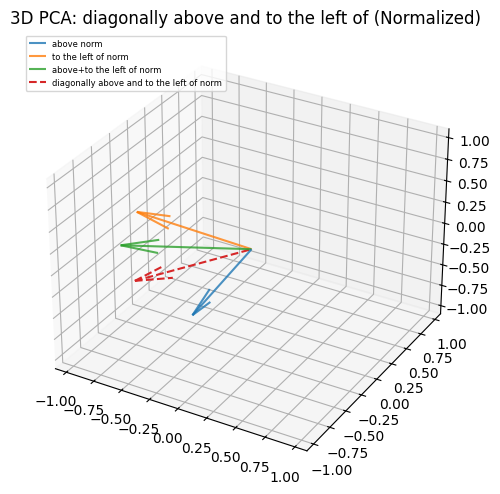

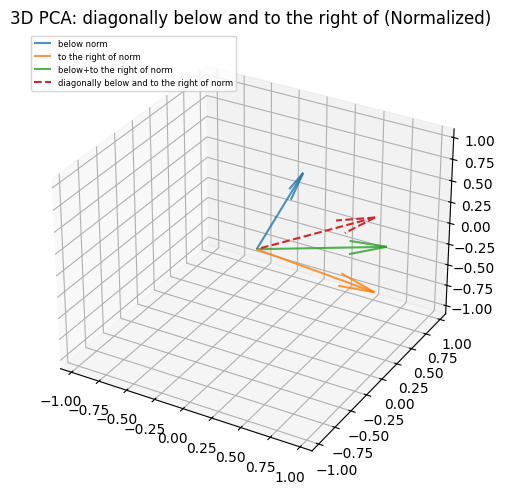

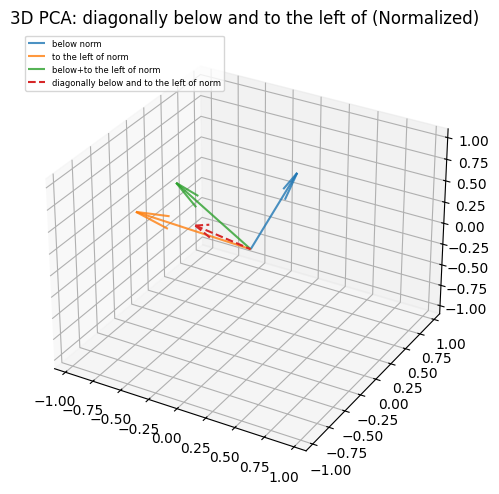

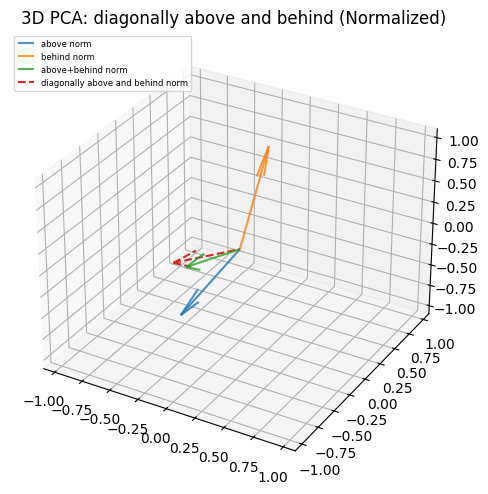

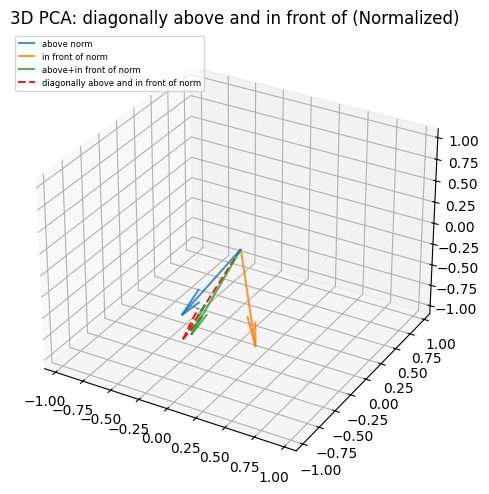

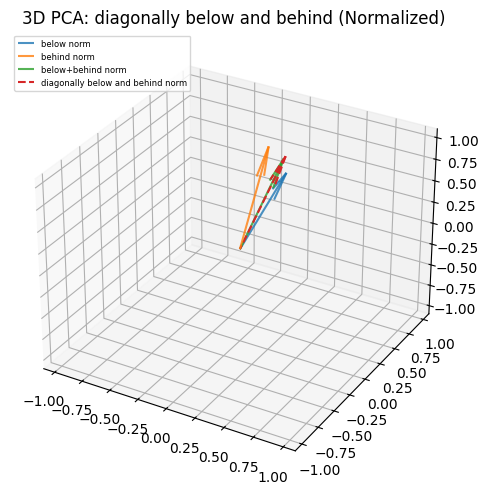

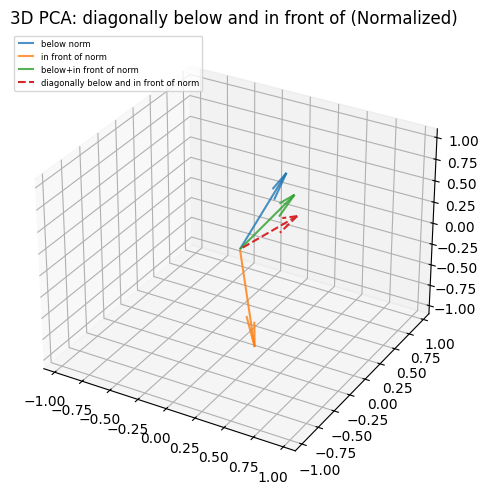

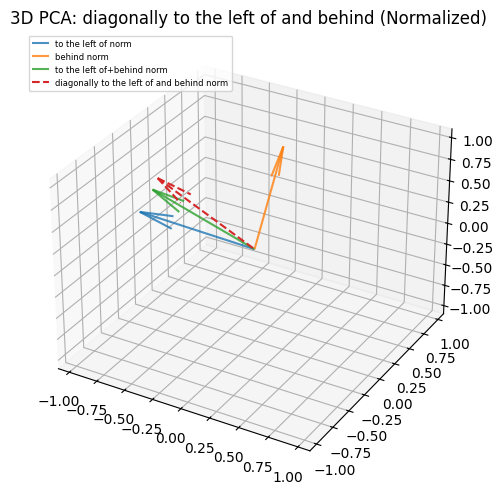

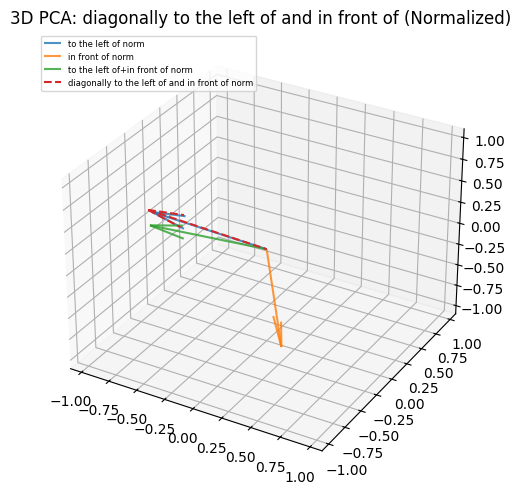

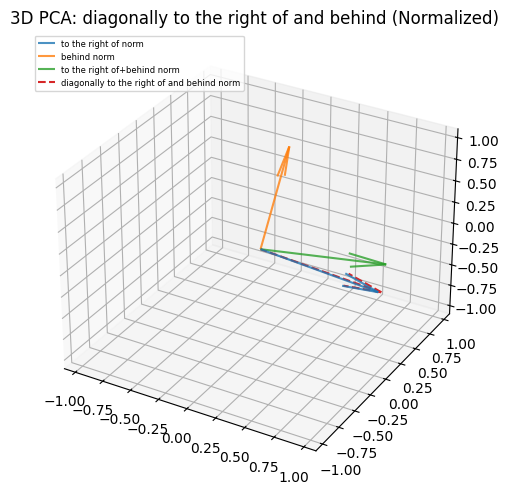

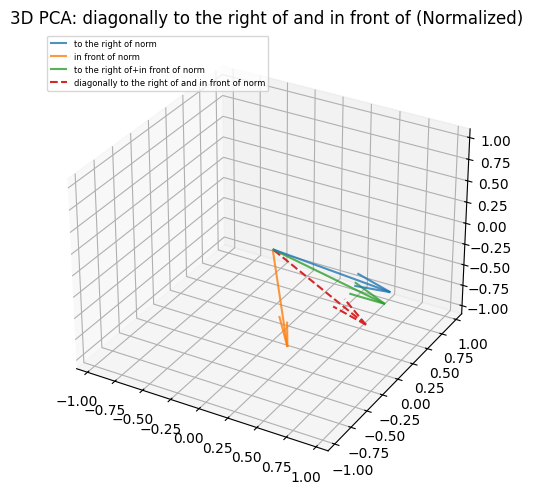

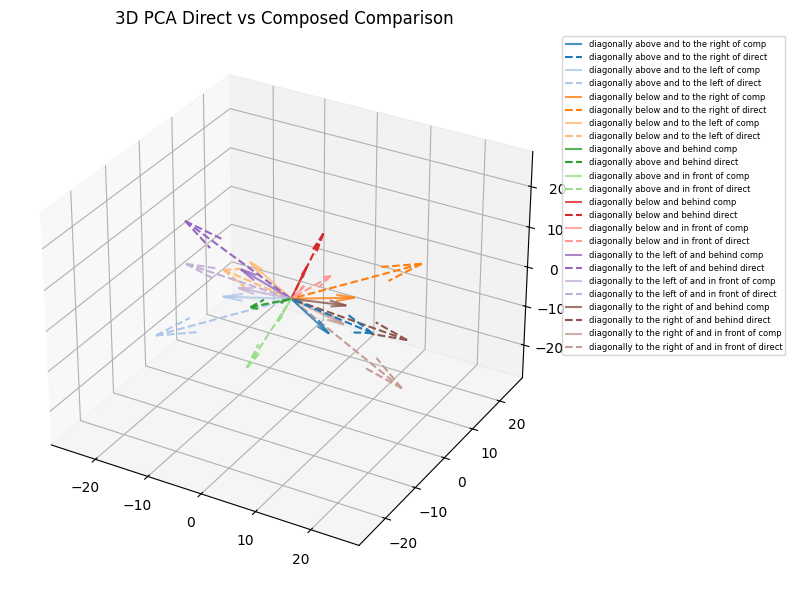

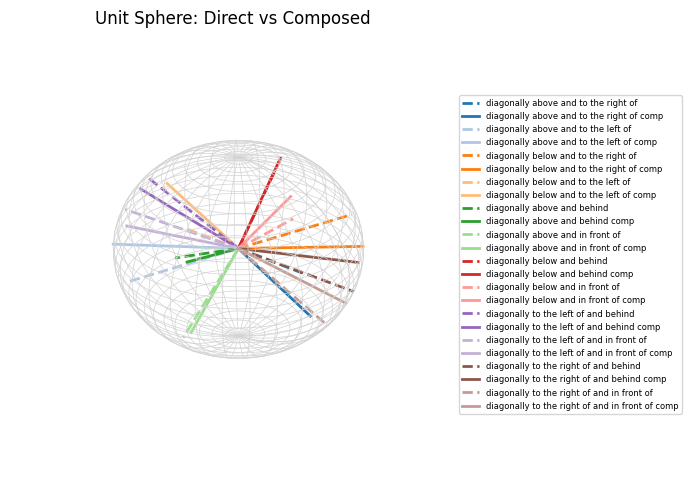

In [ ]:
# check composition of directions - 3D case
compos_directions_df = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    print(f"\nComposition of directions for layer {layer_name}")
    compos_directions_df[layer_name] = check_composition_of_directions(directions[layer_name], verbose=VERBOSE)